# exercise: Repeat the moon data exercise on California housing data

In [1]:
%reset -f
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
#plt.style.use('seaborn')
%matplotlib inline

import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import train, tune
from ray.tune.schedulers import ASHAScheduler

2025-02-01 14:07:33,014	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-01 14:07:33,251	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X,y = housing.data, housing.target

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10)

In [4]:
# create dataset

from torch.utils.data import Dataset

class HousingDataset(Dataset):
    def __init__(self,X,y):
        self.features = X
        self.labels = y

    def __getitem__(self, index):
        one_x = self.features[index]
        one_y = self.labels[index]
        return one_x, one_y

    def __len__(self):
        return self.labels.shape[0]

train_ds = HousingDataset(X_train, y_train)
test_ds = HousingDataset(X_test, y_test)

In [5]:
from torch.utils.data import DataLoader
## Question: What is the purpose of dataloader

train_loader = DataLoader(
    dataset=train_ds, batch_size=1000, shuffle=True, num_workers=0, drop_last=True
)

test_loader = DataLoader(
    dataset=test_ds, batch_size=1000, shuffle=True, num_workers=0, drop_last = True
)

In [6]:
# define your model

# model definition
class HousingModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(8, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30,20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1)
        )
    def forward(self, x):
        logits = self.layers(x)
        return logits

# instantiate the model
model = HousingModel()

In [7]:
features, labels = list(train_loader)[0]
model(features.float())

tensor([[-3.5905e+00],
        [-2.9879e+00],
        [-2.8535e+00],
        [-3.4100e+00],
        [-3.6899e+00],
        [-3.3399e+00],
        [-3.9717e+00],
        [-2.8015e+00],
        [-2.8946e+00],
        [-3.8699e+00],
        [-3.4417e+00],
        [-4.3849e+00],
        [-3.9041e+00],
        [ 4.4569e+00],
        [-3.1515e+00],
        [-3.2147e+00],
        [-3.8777e+00],
        [-3.2634e+00],
        [-1.6268e+00],
        [-3.6627e+00],
        [-4.1130e+00],
        [-2.2694e+00],
        [-3.9192e+00],
        [-3.0755e+00],
        [-3.6525e+00],
        [-2.8072e+00],
        [-3.7588e+00],
        [-3.9358e-01],
        [-2.2026e+00],
        [-3.7793e+00],
        [-3.1396e+00],
        [-3.1178e+00],
        [-3.4219e+00],
        [-2.9640e+00],
        [-1.2941e+00],
        [-3.7592e+00],
        [-3.0275e+00],
        [-2.6726e+00],
        [-3.3807e+00],
        [-3.7313e+00],
        [-4.9475e+00],
        [-3.2492e+00],
        [-2.5164e+00],
        [-1

In [19]:
def train_func(model, optimizer, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        # calculate error for this batch
        out = model(features.float())
        loss = F.mse_loss(out, labels.float())

        # update weights
        optimizer.zero_grad()  # erases maybe old stored gradients. Just to be safe
        loss.backward()        # computes gradients
        optimizer.step()       # adjust weights w_new = w_old + lr*(-grad L)

In [20]:
def test_fun(model, dataloader):
    model = model.eval()
    mses = []

    for idx, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            out = model(features.float())
        mse_loss = F.mse_loss(out,labels)
        mses.append(mse_loss)

    return torch.mean(torch.tensor(mses)).item()

In [21]:
test_fun(model, test_loader)

/tmp/ipykernel_1726/4045256349.py:8: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(out,labels)


28.958623140166505

In [22]:
import os
import tempfile

from ray.train import Checkpoint

def train_objecting_fun(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = HousingModel()
    model.to(device)

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    for i in range(10):
        train_func(model, optimizer, train_loader)
        val_mse = test_fun(model, test_loader)


        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (i + 1) % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            train.report({"val_mse": val_mse}, checkpoint=checkpoint)


In [24]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
}


tuner = tune.Tuner(
    train_objecting_fun,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        num_samples=20,
        scheduler=ASHAScheduler(metric="val_mse", mode="min"),
    ),
)
results = tuner.fit()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
2025-02-01 14:15:45,765	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/teamspace/studios/this_studio/ray_results/train_objecting_fun_2025-02-01_14-15-09' in 0.0123s.
2025-02-01 14:15:45,771	INFO tune.py:1041 -- Total run time: 36.08 seconds (36.04 seconds for the tuning loop).


In [25]:
dfs = {result.path: result.metrics_dataframe for result in results}

Text(0, 0.5, 'val_mse')

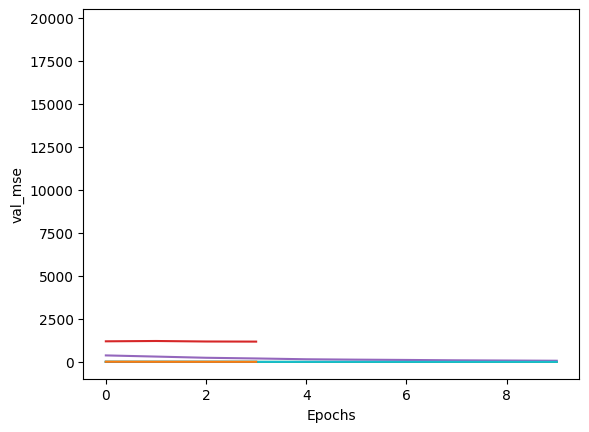

In [27]:
# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_mse.plot(ax=ax, legend=False)

ax.set_xlabel("Epochs")
ax.set_ylabel("val_mse")

In [34]:
best_result = results.get_best_result("val_mse", mode="min")
with best_result.checkpoint.as_directory() as checkpoint_dir:
    state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))


state_dict = torch.load(os.path.join(checkpoint_dir, "model.pth"))
model2 = HousingModel()
model2.load_state_dict(state_dict)

<All keys matched successfully>

In [35]:
test_fun(model2, test_loader)

/tmp/ipykernel_1726/4045256349.py:8: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(out,labels)


1.3810984157850128